In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output, display, update_display
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
from utils.helpers import *
from models.UNet import UNet
from losses.CombinedLoss import CombinedLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

max_memory = torch.cuda.get_device_properties(0).total_memory  # Общий объем памяти на GPU
used_memory = torch.cuda.memory_allocated(0)  # Используемая память на GPU
available_memory = max_memory - used_memory

print(f"Общая память GPU: {max_memory / 1e9:.2f} ГБ")
print(f"Свободная память GPU: {available_memory / 1e9:.2f} ГБ")

Using cuda
Общая память GPU: 4.29 ГБ
Свободная память GPU: 4.29 ГБ


In [2]:
transform = T.Compose([
    T.Resize((256, 256)),  # Изменение размера
    T.ToTensor(),          # Преобразование в тензор
    T.Normalize((0.5,), (0.5,))  # Нормализация
])

train_dataset = CustomDataset(root_dir='../dataset', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataset = CustomDataset(root_dir='../dataset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Пояснение:
- **perceptual_weight=0.2:**
    Радиолокационные изображения сложные, и визуальные текстуры имеют значение, но не настолько критичны, как структурные элементы.

- **ssim_weight=0.5:**
    Увеличенный вес SSIM позволит модели сосредоточиться на сохранении структурных характеристик, что важно для интерпретируемости результатов.

- **mse_weight=1.0:**
    Оставляем базовым, чтобы пиксельная ошибка оставалась основным направляющим компонентом.

- **tv_weight=0.01:**
    Малый вес TV Loss помогает устранить шум, но не доминирует над другими компонентами.

Модель создана заново.
Loss history (loss_history.npz) не найдена, начинаем сначала.


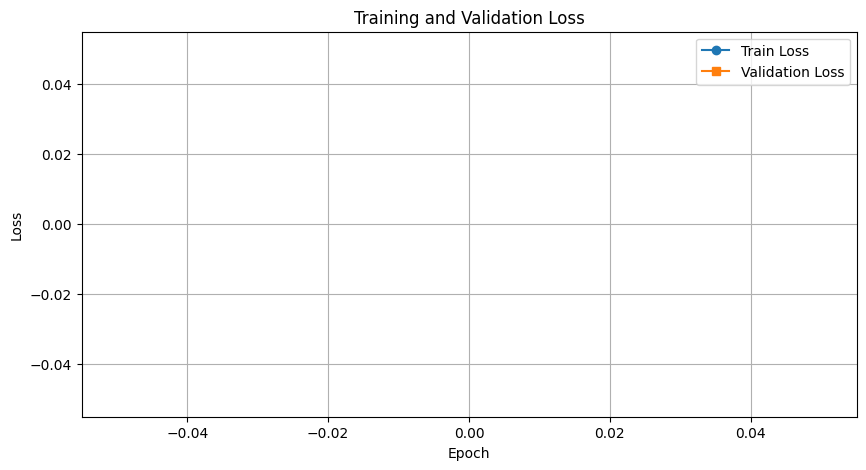

  0%|          | 0/100 [00:00<?, ?epoch/s]

c:\Users\tiruu\AppData\Local\Programs\Python\Python39\lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.9))
criterion = CombinedLoss(
    perceptual_weight=0.2,  # Умеренный вес для перцептивной потери
    ssim_weight=0.5,       # Усиленный вес для сохранения структуры
    mse_weight=1.0,        # Базовый вес для пиксельной ошибки
    tv_weight=0.00         # Малый вес для сглаживания
).to(device)
# criterion = nn.MSELoss()

checkpoint_path = os.path.join("checkpoints", "best_model.pth")
start_epoch = 0

if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer)
else:
    print("Модель создана заново.")

# Early stopping параметры
patience = 10
best_test_loss = float('inf')
wait = 0

# Логирование
train_loss_history, test_loss_history = load_loss_history("loss_history.npz")
# Инициализация графика (вне цикла)
plt.ion()
fig, ax = plt.subplots(figsize=(10, 5))
train_line, = ax.plot(
    range(len(train_loss_history)),
    train_loss_history,
    label="Train Loss",
    marker='o',   # Добавляем маркеры (точки)
    linestyle='-'  # Линия соединяет точки
)

test_line, = ax.plot(
    range(len(test_loss_history)),
    test_loss_history,
    label="Validation Loss",
    marker='s',   # Маркеры для тестовой кривой
    linestyle='-'  # Линия соединяет точки
)

ax.relim()  # Пересчитываем границы
ax.autoscale_view(scalex=True, scaley=True)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss")
ax.legend()
ax.grid(True)

# Отображение графика в отдельной ячейке
display(fig, display_id="loss_graph")

from torch.amp import autocast, GradScaler  # Импорт необходимых инструментов

# Инициализация масштабировщика градиентов
scaler = GradScaler()

# Количество эпох
total_epochs = 100
with tqdm(total=total_epochs, unit='epoch', initial=start_epoch) as pbar:
    for epoch in range(start_epoch , total_epochs):
        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"NaN detected in gradients for {name}")

        if epoch == start_epoch:  # Пропускаем обработку загруженной эпохи
            continue

        model.train()
        train_loss = 0
        for imgA, imgB in train_loader:
            imgA, imgB = imgA.to(device), imgB.to(device)

            optimizer.zero_grad()
            with autocast('cuda'):
                outputs = model(imgA)
                loss = criterion(outputs, imgB)

            scaler.scale(loss).backward() # loss.backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
        train_loss_history.append(train_loss)

        # Оценка на тестовом наборе
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for imgA, imgB in test_loader:
                imgA, imgB = imgA.to(device), imgB.to(device)
                outputs = model(imgA)
                loss = criterion(outputs, imgB)
                    
                test_loss += loss.item()
        test_loss_history.append(test_loss)

        # Сохранение истории потерь после каждой эпохи
        save_loss_history(train_loss_history, test_loss_history, "loss_history.npz")

        # Ранняя остановка
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            wait = 0
            save_best_model(epoch, model, optimizer, test_loss, checkpoint_path)  # Сохранение только лучшей модели
        else:
            wait += 1
            if wait >= patience:
                pbar.set_description(f"Early stopping triggered at epoch {epoch}")  # Обновляем описание tqdm
                pbar.update(1)
                break

        # Обновление tqdm
        pbar.set_description(f"Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}")
        pbar.update(1)

        # График потерь
        train_line.set_data(range(len(train_loss_history)), train_loss_history)
        test_line.set_data(range(len(test_loss_history)), test_loss_history)
        ax.relim()  # Пересчитываем границы
        ax.autoscale_view(scalex=True, scaley=True)  # Автоматически обновляем масштаб
        update_display(fig, display_id="loss_graph")  # Обновляем график в ячейке

# Загрузка лучшей модели
model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
print("Загружена лучшая модель!")